Random state = 3, noise = 0.18 for makemoons and random state for train test split = 12

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic', epsilon=1e-4,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon
        self.track_history = track_history
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        y_range = y_max - y_min
        self.control_x = np.linspace(x_min, x_max, self.n_control_points)
        y_mid = (self.m0[1] + self.m1[1]) / 2
        self.control_y = np.random.uniform(y_mid - y_range * 0.05, y_mid + y_range * 0.05, self.n_control_points)
        # Removed: self.control_y[0] = self.control_y[1], self.control_y[-1] = self.control_y[-2]
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()

    def _fit_spline(self):
        # Ensure control_x is strictly increasing
        sorted_idx = np.argsort(self.control_x)
        self.control_x = self.control_x[sorted_idx]
        self.control_y = self.control_y[sorted_idx]
        if self.spline_type == 'cubic':
            self.spline = CubicSpline(self.control_x, self.control_y, bc_type='natural')  # Changed to natural for flexibility
        else:
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        return X[:, 1] - self.spline(X[:, 0])

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y):
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y)
        errors = displacements * pseudo_labels <= 0
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            return np.zeros_like(self.control_x), np.zeros_like(self.control_y)

        X_err = X[error_indices, 0]
        y_err = y[error_indices]
        ti = np.where(y_err == 1, 1, -1)
        sign_theta = self.class_1_pseudo

        base_spline = self.spline(X_err)
        n_points = len(self.control_x)
        grad_x = np.zeros(n_points)
        grad_y = np.zeros(n_points)
        perturbed_diff_x = np.zeros((n_points, len(X_err)))
        perturbed_diff_y = np.zeros((n_points, len(X_err)))

        # Vectorized gradients for both x and y
        for j in range(n_points):
            # Perturb x
            control_x_pert = self.control_x.copy()
            control_x_pert[j] += self.epsilon
            sorted_idx = np.argsort(control_x_pert)
            if self.spline_type == 'cubic':
                spline_pert = CubicSpline(control_x_pert[sorted_idx], self.control_y[sorted_idx], bc_type='natural')
            else:
                spline_pert = PchipInterpolator(control_x_pert[sorted_idx], self.control_y[sorted_idx])
            perturbed_diff_x[j] = spline_pert(X_err) - base_spline

            # Perturb y
            control_y_pert = self.control_y.copy()
            control_y_pert[j] += self.epsilon
            if self.spline_type == 'cubic':
                spline_pert = CubicSpline(self.control_x, control_y_pert, bc_type='natural')
            else:
                spline_pert = PchipInterpolator(self.control_x, control_y_pert)
            perturbed_diff_y[j] = spline_pert(X_err) - base_spline

        grad_x += (ti * sign_theta) @ (perturbed_diff_x.T / self.epsilon)
        grad_y += (ti * sign_theta) @ (perturbed_diff_y.T / self.epsilon)

        # Regularization for both x and y
        grad_x[1:] += 2 * self.lambda_reg * (self.control_x[1:] - self.control_x[:-1])
        grad_x[:-1] -= 2 * self.lambda_reg * (self.control_x[1:] - self.control_x[:-1])
        grad_y[1:] += 2 * self.lambda_reg * (self.control_y[1:] - self.control_y[:-1])
        grad_y[:-1] -= 2 * self.lambda_reg * (self.control_y[1:] - self.control_y[:-1])

        return grad_x, grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_x = self.control_x.copy()
        best_control_y = self.control_y.copy()
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [(self.control_x.copy(), self.control_y.copy())]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            error_count = np.sum(displacements * pseudo_labels <= 0)

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

            grad_x, grad_y = self._compute_gradients(X, y)
            self.control_x -= current_lr * grad_x
            self.control_y -= current_lr * grad_y
            self._fit_spline()

        self.control_x = best_control_x
        self.control_y = best_control_y
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

    def plot_boundary(self, X, y, figsize=(8, 6)):
        fig = plt.figure(figsize=figsize)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)
        x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

        if self.spline_type == 'cubic':
            initial_spline = CubicSpline(self.initial_control_x, self.initial_control_y, bc_type='natural')
        else:
            initial_spline = PchipInterpolator(self.initial_control_x, self.initial_control_y)
        y_initial = initial_spline(x_range)
        plt.plot(x_range, y_initial, 'r--', label='Initial Boundary', alpha=0.7)

        y_final = self.spline(x_range)
        plt.plot(x_range, y_final, 'g-', label='Final Boundary')

        plt.scatter(self.initial_control_x, self.initial_control_y, c='orange', marker='o',
                    label='Initial Control Points', alpha=0.7)
        plt.scatter(self.control_x, self.control_y, c='k', marker='x',
                    label='Final Control Points')

        plt.legend()
        plt.title('GradientSMPA Decision Boundary: Initial vs Final')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        return fig

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

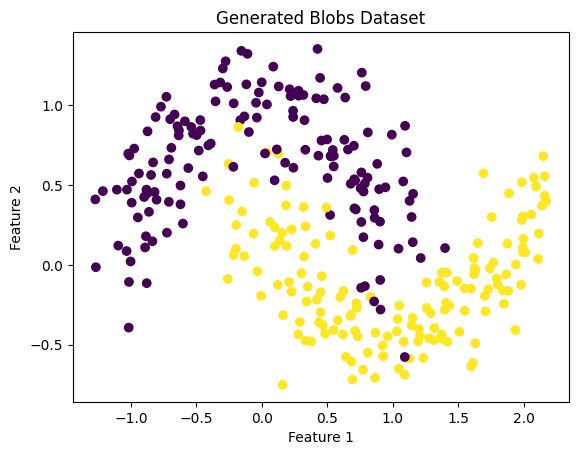

In [3]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.18)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [4]:
model = GradientSMPA(
    learning_rate=0.05,        # Moderate step size for gradient updates
    epochs=300,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.000001,           # Light regularization to prevent wild spline jumps
    patience=10,                # Standard patience for LR decay
    decay_factor=0.99,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=7,        # Flexible but not overkill
    smoothing_factor=0.000001,      # Your original smoothing, works well
    spline_type='cubic',       # Smooth and differentiable
    epsilon=1e-8,               # Small perturbation for numerical gradients
    track_history=True
)

In [5]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 42, LR = 0.050000
Epoch 5: Errors = 39, LR = 0.050000
Epoch 10: Errors = 39, LR = 0.050000
Epoch 15: Errors = 38, LR = 0.050000
Epoch 20: Errors = 34, LR = 0.050000
Epoch 25: Errors = 32, LR = 0.050000
Epoch 30: Errors = 29, LR = 0.050000
Epoch 35: Errors = 28, LR = 0.050000
Epoch 40: Errors = 25, LR = 0.050000
Epoch 45: Errors = 25, LR = 0.050000
Epoch 50: Errors = 24, LR = 0.049500
Epoch 55: Errors = 24, LR = 0.049500
Epoch 60: Errors = 21, LR = 0.049500
Epoch 65: Errors = 21, LR = 0.049500
Epoch 70: Errors = 21, LR = 0.049500
Epoch 75: Errors = 19, LR = 0.049500
Epoch 80: Errors = 19, LR = 0.049500
Epoch 85: Errors = 23, LR = 0.049005
Epoch 90: Errors = 23, LR = 0.049005
Epoch 95: Errors = 23, LR = 0.048515
Epoch 100: Errors = 25, LR = 0.048515
Epoch 105: Errors = 28, LR = 0.048030
Epoch 110: Errors = 33, LR = 0.048030
Epoch 115: Errors = 205, LR = 0.047550
Epoch 120: Errors = 200, LR = 0.047550
Epoch 125: Errors = 51, LR = 0.047074
Epoch 130: Errors = 184, LR = 0.

GradientSMPA(decay_factor=0.99, epochs=300, epsilon=1e-08, lambda_reg=1e-06,
             n_control_points=7, random_state=11, smoothing_factor=1e-06,
             track_history=True, verbose=True)

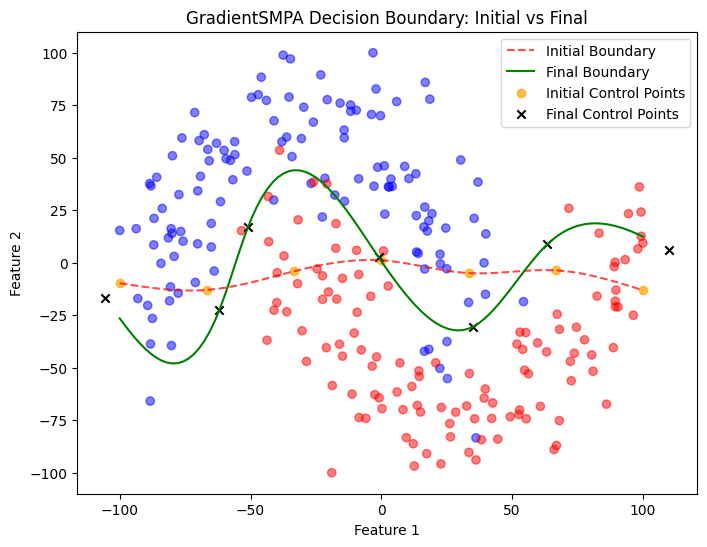

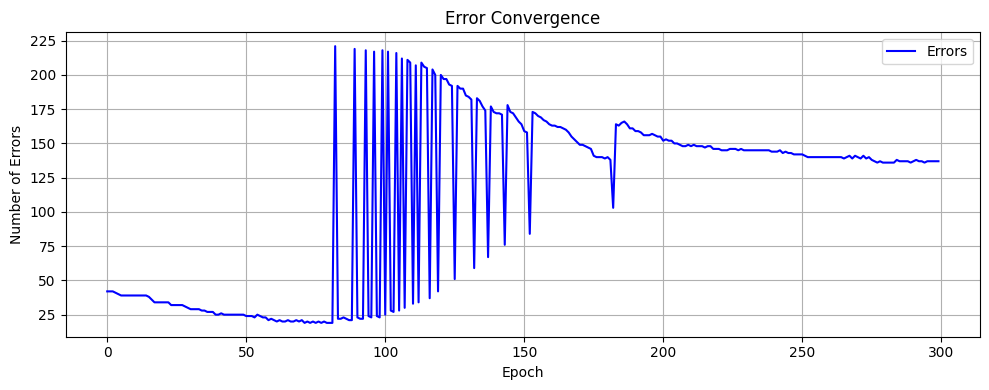

In [6]:
# Plot the decision boundary and convergence
model.plot_boundary(X_train_minmax, y_train)
model.plot_convergence()
plt.show()

In [7]:
from sklearn.metrics import classification_report

In [8]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.94      0.91      0.92        32

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



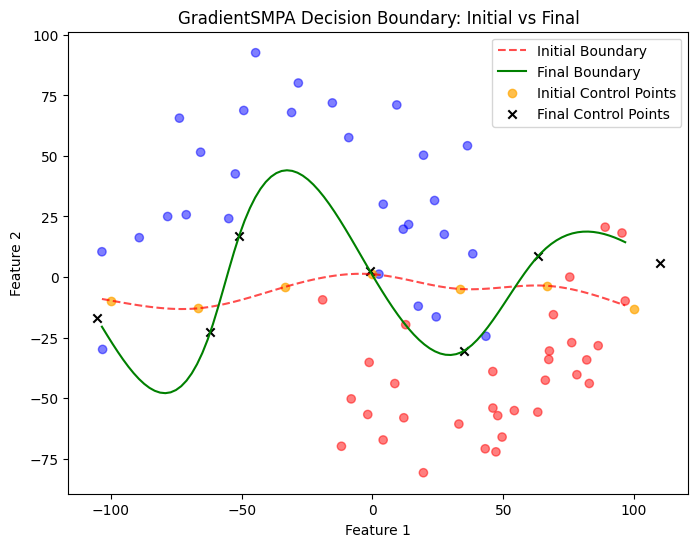

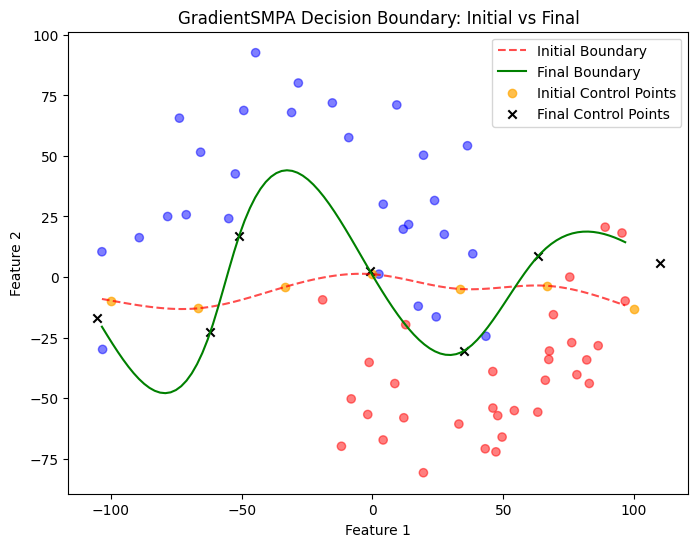

In [9]:
model.plot_boundary(X_test_minmax, y_test)

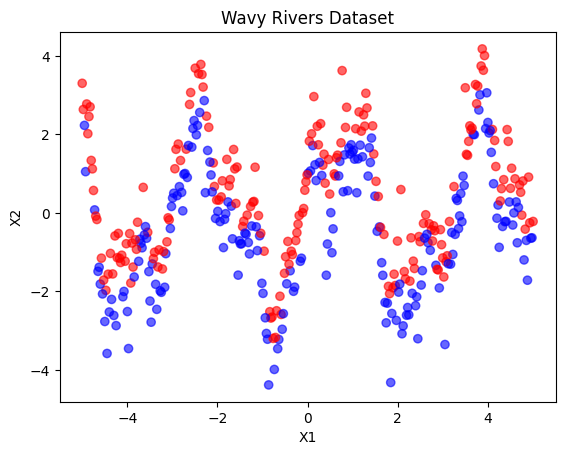

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wavy_rivers(n_samples=400, noise=0.2, random_state=7):
    """
    Generate a 2D dataset with two classes separated by a squiggly, single-valued boundary.

    Parameters:
    - n_samples: Total number of points (split evenly between classes)
    - noise: Amount of random perturbation
    - random_state: Seed for reproducibility

    Returns:
    - X: 2D array of shape (n_samples, 2)
    - y: Labels array of shape (n_samples,)
    """
    np.random.seed(random_state)
    n_per_class = n_samples // 2

    # Generate x values
    x = np.linspace(-5, 5, n_samples)
    np.random.shuffle(x)
    x_class0 = x[:n_per_class]
    x_class1 = x[n_per_class:]

    # Define a squiggly boundary function (single-valued)
    boundary = (np.sin(2 * x) + 0.5 * np.cos(5 * x) + 0.3 * np.sin(10 * x)) * 2

    # Class 0: Points below the boundary with noise
    y_class0 = boundary[:n_per_class] - np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Class 1: Points above the boundary with noise
    y_class1 = boundary[n_per_class:] + np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Combine into dataset
    X = np.vstack([
        np.column_stack([x_class0, y_class0]),
        np.column_stack([x_class1, y_class1])
    ])
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])

    # Shuffle
    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

# Test it
X, y = generate_wavy_rivers(n_samples=400, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [31]:
model = GradientSMPA(
    learning_rate=0.3,        # Moderate step size for gradient updates
    epochs=400,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.000001,           # Light regularization to prevent wild spline jumps
    patience=15,                # Standard patience for LR decay
    decay_factor=0.9,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=8,        # Flexible but not overkill
    smoothing_factor=0.0000001,      # Your original smoothing, works well
    spline_type='cubic',       # Smooth and differentiable
    epsilon=1e-6,               # Small perturbation for numerical gradients
    track_history=True
)

In [32]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 137, LR = 0.300000
Epoch 5: Errors = 109, LR = 0.300000
Epoch 10: Errors = 191, LR = 0.300000


Epoch 15: Errors = 192, LR = 0.300000
Epoch 20: Errors = 196, LR = 0.300000
Epoch 25: Errors = 197, LR = 0.270000
Epoch 30: Errors = 193, LR = 0.270000
Epoch 35: Errors = 201, LR = 0.270000
Epoch 40: Errors = 194, LR = 0.243000
Epoch 45: Errors = 195, LR = 0.243000
Epoch 50: Errors = 194, LR = 0.243000
Epoch 55: Errors = 198, LR = 0.218700
Epoch 60: Errors = 199, LR = 0.218700
Epoch 65: Errors = 196, LR = 0.218700
Epoch 70: Errors = 199, LR = 0.196830
Epoch 75: Errors = 202, LR = 0.196830
Epoch 80: Errors = 201, LR = 0.196830
Epoch 85: Errors = 199, LR = 0.177147
Epoch 90: Errors = 199, LR = 0.177147
Epoch 95: Errors = 197, LR = 0.177147
Epoch 100: Errors = 198, LR = 0.159432
Epoch 105: Errors = 199, LR = 0.159432
Epoch 110: Errors = 109, LR = 0.159432
Epoch 115: Errors = 213, LR = 0.143489
Epoch 120: Errors = 98, LR = 0.143489
Epoch 125: Errors = 208, LR = 0.143489
Epoch 130: Errors = 203, LR = 0.143489
Epoch 135: Errors = 207, LR = 0.129140
Epoch 140: Errors = 202, LR = 0.129140
Epoc

GradientSMPA(epochs=400, epsilon=1e-06, lambda_reg=1e-06, learning_rate=0.3,
             n_control_points=8, patience=15, random_state=11,
             smoothing_factor=1e-07, track_history=True, verbose=True)

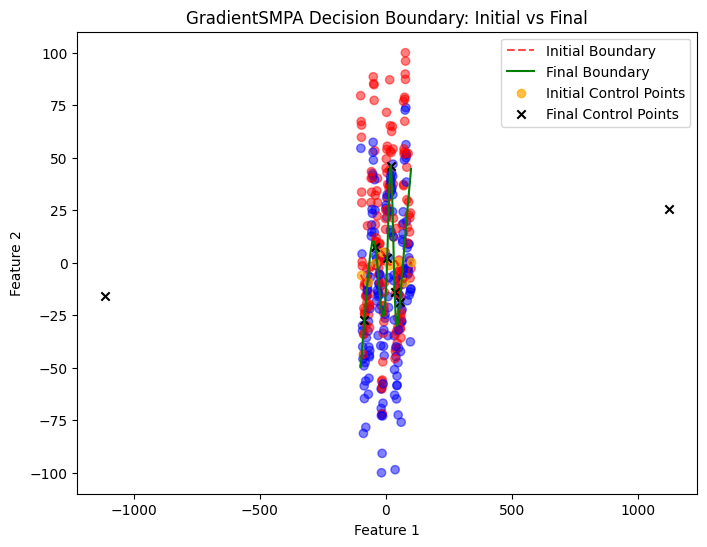

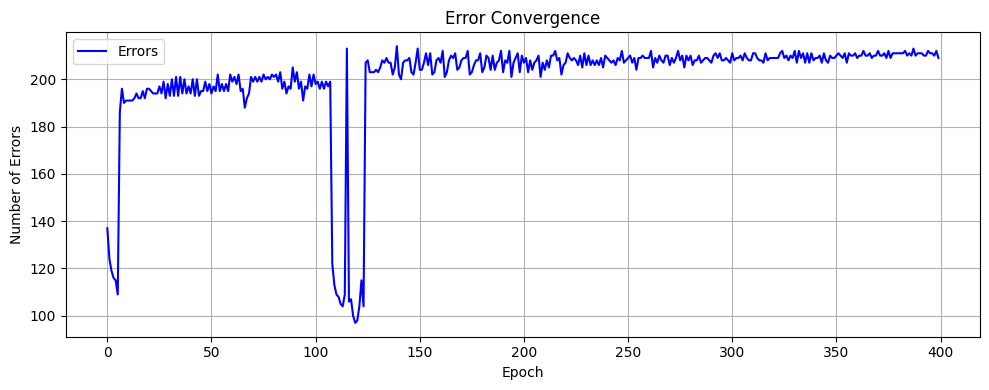

In [33]:
# Plot the decision boundary and convergence
model.plot_boundary(X_train_minmax, y_train)
model.plot_convergence()
plt.show()

In [34]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.56      0.57        39
         1.0       0.60      0.61      0.60        41

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80



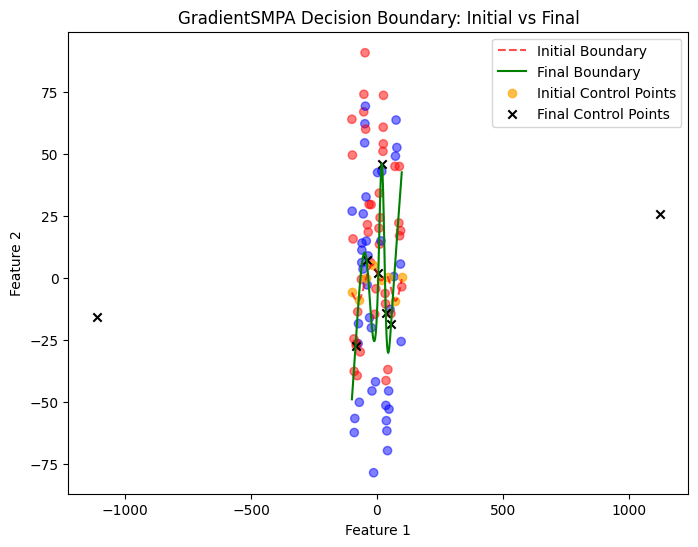

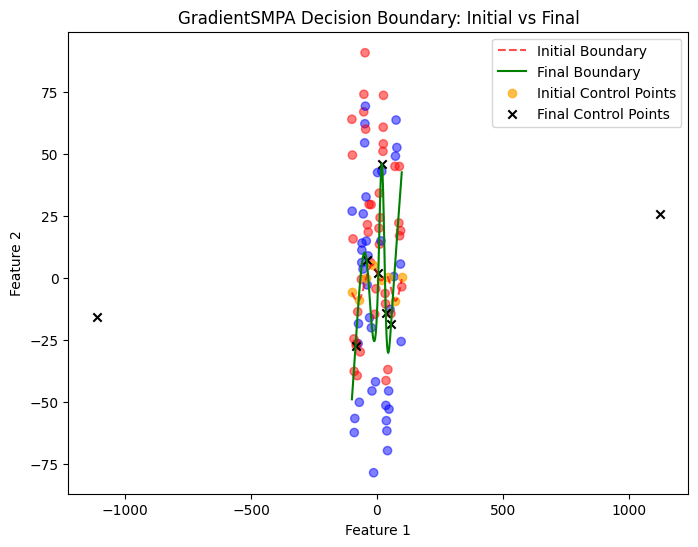

In [16]:
model.plot_boundary(X_test_minmax, y_test)

In [17]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import make_smoothing_spline

class MPA2D_Spline(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_lambda=0.1):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_lambda = smoothing_lambda
        self.error_history_ = []
        self.learning_rate_history_ = []
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        np.random.seed(random_state)

    def _calculate_means(self, X, y):
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        self.control_x = np.linspace(x_min, x_max, self.n_control_points).copy()  # Make it adjustable
        y_mid = (self.m0[1] + self.m1[1]) / 2
        self.control_y = np.random.uniform(y_mid - (y_max - y_min) * 0.1,
                                          y_mid + (y_max - y_min) * 0.1,
                                          self.n_control_points)
        self.initial_control_x = self.control_x.copy()  # Store initial x too
        self.initial_control_y = self.control_y.copy()

    def _fit_spline(self):
        self.spline = make_smoothing_spline(self.control_x, self.control_y, lam=self.smoothing_lambda)

    def _calculate_displacement(self, X):
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")
        X = np.asarray(X)
        y = np.asarray(y)

        self._calculate_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        self.error_history_ = []
        self.learning_rate_history_ = []

        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        for epoch in range(self.epochs):
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min LR reached at epoch {epoch}")
                        break

            if errors.any():
                error_indices = np.where(errors)[0]
                for idx in error_indices:
                    d = X[idx]
                    distances = np.abs(self.control_x - d[0])
                    nearest_idx = np.argmin(distances)
                    distance = distances[nearest_idx]
                    lmbda = (np.log1p(distance) if self.lambda_scaling == 'log' else
                            np.sqrt(distance) if self.lambda_scaling == 'sqrt' else distance)

                    # Determine opposite class's correctly classified points
                    if y[idx] == 1:  # Misclassified class 1 point
                        opp_indices = indices_class_0
                    else:  # Misclassified class 0 point
                        opp_indices = indices_class_1

                    # Find correctly classified points in opposite class
                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > 0]

                    if len(correct_opp) > 0:
                        # Average 2D position of correctly classified opposite class points
                        avg_opp = np.mean(X[correct_opp], axis=0)  # [avg_opp_x, avg_opp_y]
                        # Calculate 2D difference to move towards avg_opp
                        delta_x = avg_opp[0] - self.control_x[nearest_idx]
                        delta_y = avg_opp[1] - self.control_y[nearest_idx]
                        # Apply step in both directions
                        step_x = delta_x * lmbda * current_learning_rate
                        step_y = delta_y * lmbda * current_learning_rate

                        # Constrain step_x to maintain ascending order
                        if nearest_idx > 0:
                            min_x = self.control_x[nearest_idx - 1] + 1e-6  # Small buffer to avoid equality
                            step_x = max(step_x, min_x - self.control_x[nearest_idx])
                        if nearest_idx < len(self.control_x) - 1:
                            max_x = self.control_x[nearest_idx + 1] - 1e-6
                            step_x = min(step_x, max_x - self.control_x[nearest_idx])
                    else:
                        # Fallback: Use original direction (y-only) if no correct points
                        step_x = 0  # No x movement in fallback
                        step_y = -pseudo_labels[idx] * lmbda * current_learning_rate

                    self.control_x[nearest_idx] += step_x
                    self.control_y[nearest_idx] += step_y

        # Store the last control points from the final epoch
        self.last_control_x = self.control_x.copy()
        self.last_control_y = self.control_y.copy()
        # Restore best for prediction
        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def plot_convergence(self, figsize=(12, 5)):
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)
            plt.tight_layout()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def plot_boundary(self, X, y, figsize=(8, 6)):
        try:
            import matplotlib.pyplot as plt
            fig = plt.figure(figsize=figsize)
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)

            # Plot initial spline
            initial_spline = make_smoothing_spline(self.initial_control_x, self.initial_control_y, lam=self.smoothing_lambda)
            x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
            y_initial = initial_spline(x_range)
            plt.plot(x_range, y_initial, 'r--', label='Initial Boundary', alpha=0.7)

            # Plot last spline (from final epoch)
            last_spline = make_smoothing_spline(self.last_control_x, self.last_control_y, lam=self.smoothing_lambda)
            y_last = last_spline(x_range)
            plt.plot(x_range, y_last, 'g-', label='Last Boundary')

            # Plot control points
            plt.scatter(self.initial_control_x, self.initial_control_y, c='orange', marker='o', label='Initial Control Points', alpha=0.7)
            plt.scatter(self.last_control_x, self.last_control_y, c='k', marker='x', label='Last Control Points')

            plt.legend()
            plt.title('MPA2D_Spline Decision Boundary: Initial vs Last')
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

In [18]:
# Initialize and fit the model
model2 = MPA2D_Spline(
    learning_rate=0.01,
    epochs=150,
    verbose=True,
    n_control_points=8,
    smoothing_lambda=0.00001,
    decay_factor=0.99,
    random_state = 12
)

In [19]:
model2.fit(X_train_minmax, y_train)

Epoch 0: Errors = 134, LR = 0.010000
Epoch 10: Errors = 143, LR = 0.009900
Epoch 20: Errors = 148, LR = 0.009703
Epoch 30: Errors = 149, LR = 0.009510
Epoch 40: Errors = 150, LR = 0.009321
Epoch 50: Errors = 144, LR = 0.009135
Epoch 60: Errors = 151, LR = 0.008953
Epoch 70: Errors = 150, LR = 0.008775
Epoch 80: Errors = 146, LR = 0.008601
Epoch 90: Errors = 146, LR = 0.008429
Epoch 100: Errors = 144, LR = 0.008262
Epoch 110: Errors = 143, LR = 0.008097
Epoch 120: Errors = 144, LR = 0.007936
Epoch 130: Errors = 144, LR = 0.007778
Epoch 140: Errors = 173, LR = 0.007623


MPA2D_Spline(decay_factor=0.99, epochs=150, learning_rate=0.01,
             n_control_points=8, random_state=12, smoothing_lambda=1e-05,
             verbose=True)

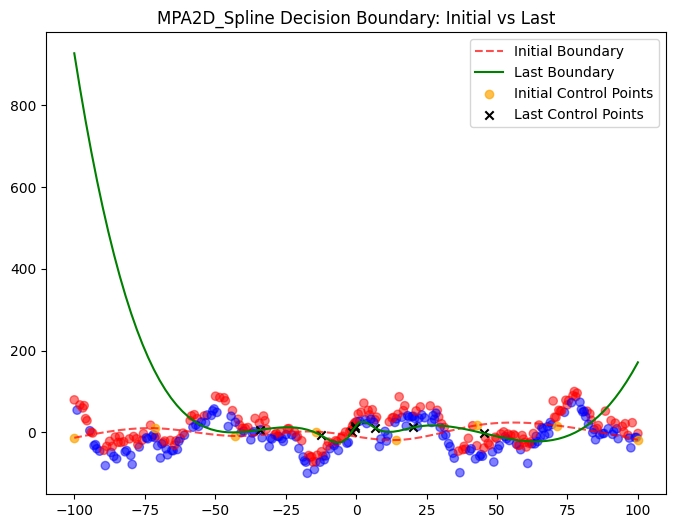

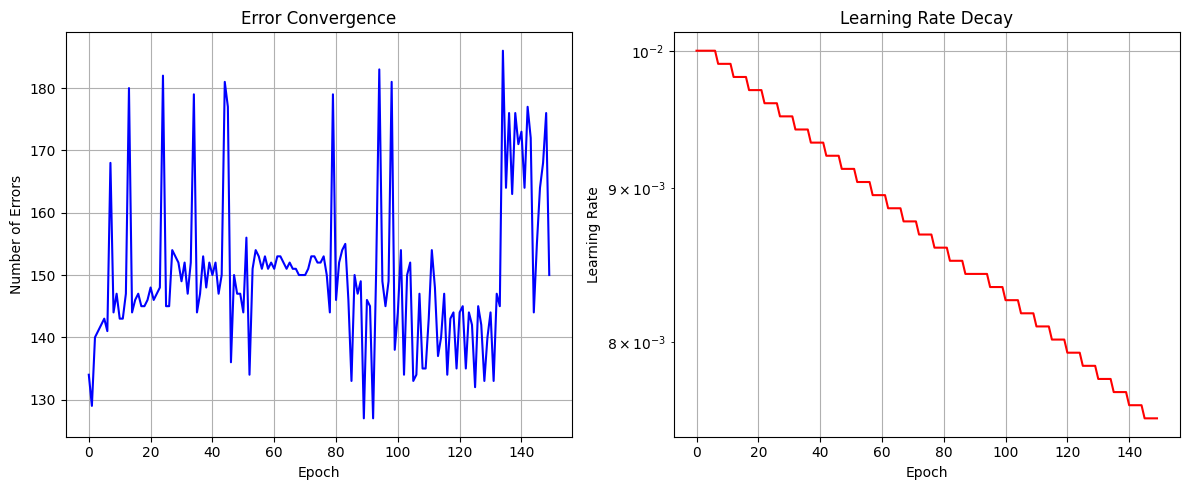

In [20]:
# Plot the decision boundary and convergence
model2.plot_boundary(X_train_minmax, y_train)
model2.plot_convergence()
plt.show()

In [21]:
print("\nClassification Report:")
print(classification_report(y_test,model2.predict(X_test_minmax)))
cr = classification_report(y_test, model2.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        39
         1.0       0.63      0.59      0.61        41

    accuracy                           0.61        80
   macro avg       0.61      0.61      0.61        80
weighted avg       0.61      0.61      0.61        80



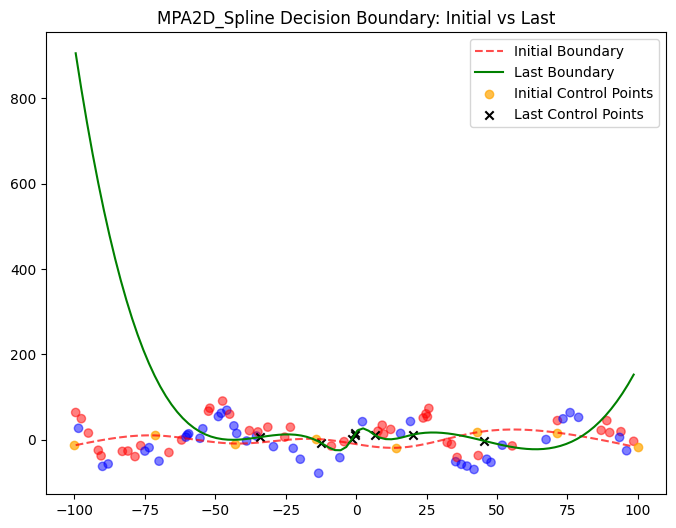

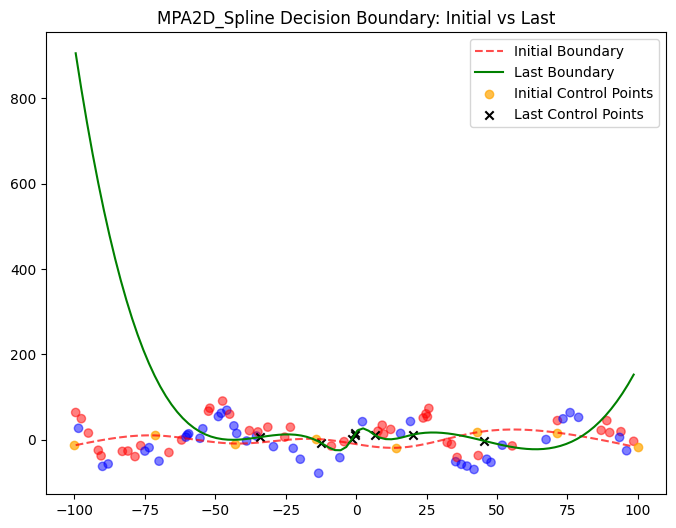

In [22]:
model2.plot_boundary(X_test_minmax, y_test)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=42)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.64
Test set score with best model: 0.46


In [26]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test_scaled)))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.67      0.68        39
         1.0       0.70      0.73      0.71        41

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80



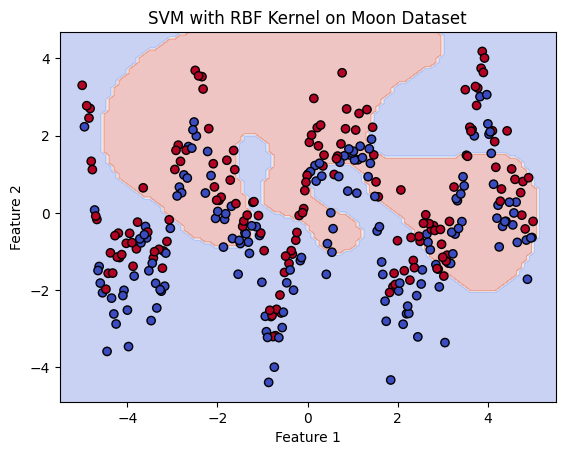

In [27]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

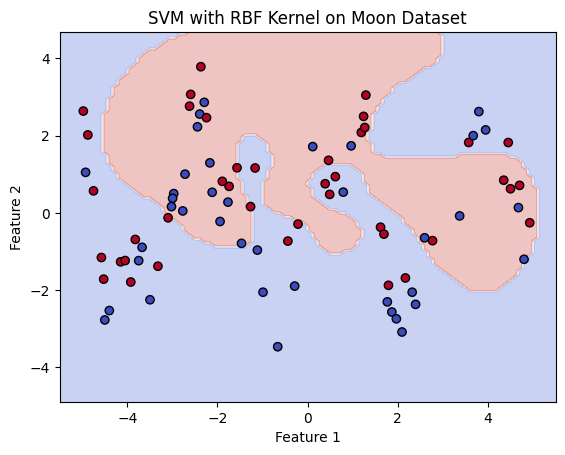

In [28]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()